In [2]:
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt

# Reading images

The image has already been segmented producing a mask with the object.

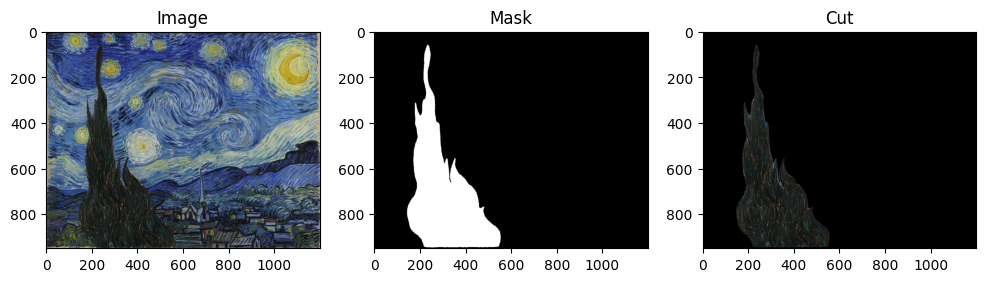

In [3]:
img = cv2.cvtColor(cv2.imread('images/van.png'), cv2.COLOR_BGR2RGB)
inpainted_background = cv2.cvtColor(cv2.imread('images/back.png'), cv2.COLOR_BGR2RGB)
mask = cv2.imread('masks/van_mask001.png.png')
cut_img = cv2.bitwise_and(img, mask)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(img)
axs[0].set_title('Image')

axs[1].imshow(mask)
axs[1].set_title('Mask')

axs[2].imshow(cut_img)
axs[2].set_title('Cut')

plt.show()

# Background

To avoid empty pixels where the object used to be we will fill the object with the average color around the object.

## Getting average color

To obtain the average color around the object we will dilate the mask and substract the original mask. We will calculate the average over the difference.

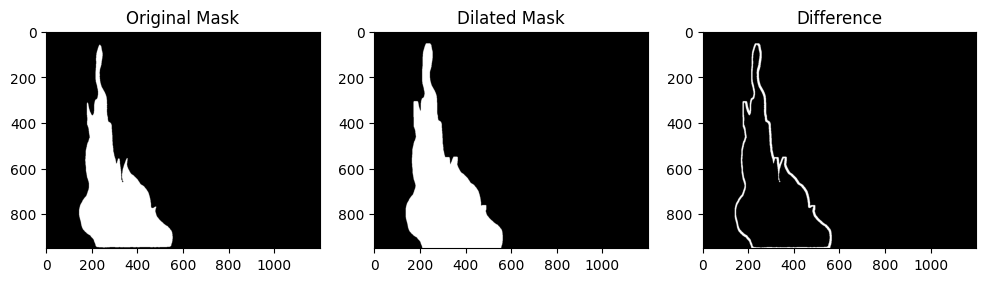

In [4]:
dilated_mask = cv2.dilate(mask, np.ones((6, 6), np.uint8), iterations=3)
difference = cv2.subtract(dilated_mask, mask)

# Display
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(mask)
axs[0].set_title('Original Mask')

axs[1].imshow(dilated_mask)
axs[1].set_title('Dilated Mask')

axs[2].imshow(difference)
axs[2].set_title('Difference')

plt.show()

## Filling with the average

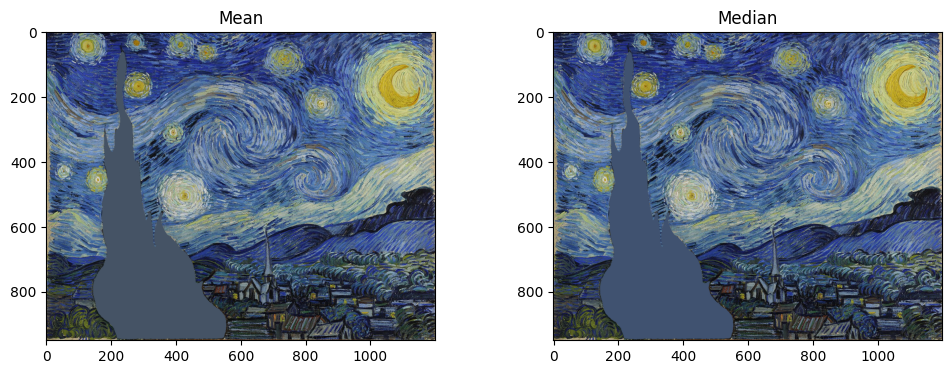

In [5]:
edges = cv2.bitwise_and(img, difference)

mean_color = np.mean(edges[edges.sum(axis=2) > 0], axis=0)
median_color = np.median(edges[edges.sum(axis=2) > 0], axis=0)

mask_bool = mask.any(axis=2).astype(bool)

background_mean = img.copy()
background_mean[mask_bool] = mean_color

background_median = img.copy()
background_median[mask_bool] = median_color

# Display
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].imshow(background_mean)
axs[0].set_title('Mean')

axs[1].imshow(background_median)
axs[1].set_title('Median')

plt.show()

## Inpainting

CV2 also offers a fully computer vision algorithm for inpainting. Two options based on the papers:

* An Image Inpainting Technique Based on the Fast Marching Method (TELEA)
* Navier-Stokes, Fluid Dynamics, and Image and Video Inpainting (NS)

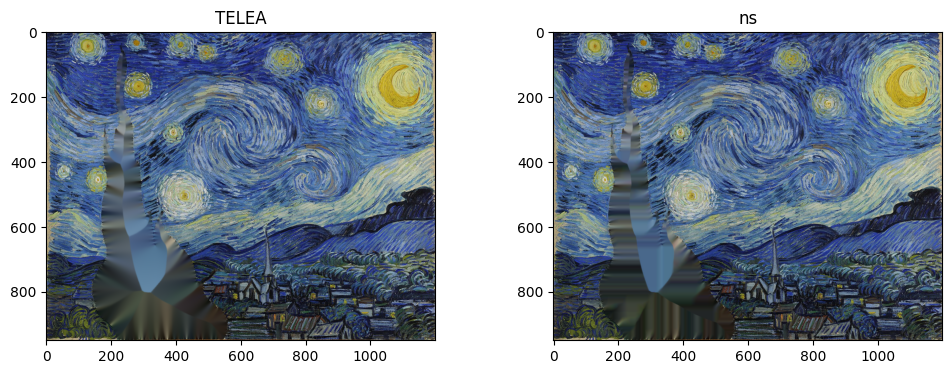

In [6]:
mask_gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
telea = cv2.inpaint(img, mask_gray, 3, cv2.INPAINT_TELEA)
ns = cv2.inpaint(img, mask_gray, 3, cv2.INPAINT_NS)

# Display
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].imshow(telea)
axs[0].set_title('TELEA')

axs[1].imshow(ns)
axs[1].set_title('ns')

plt.show()

# Local augmentations

First we select the bounding box for the element to augment.

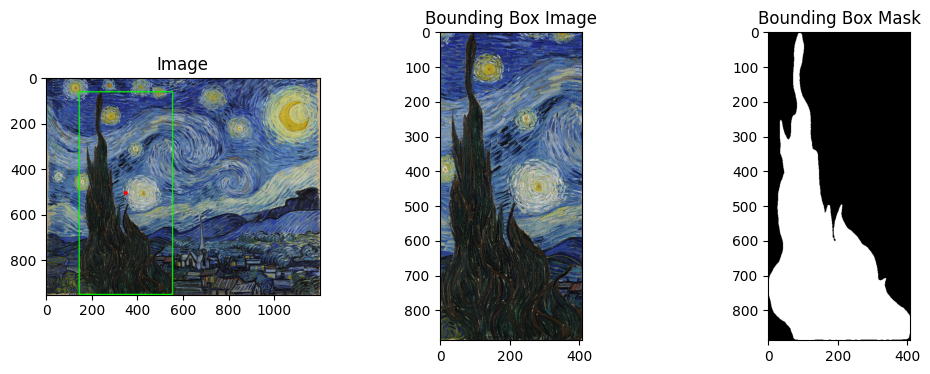

In [7]:
def get_bounding_box(mask):
    """
    Calculates the bounding box of a given mask.

    Parameters:
    mask (numpy.ndarray): The input mask.

    Returns:
    dict: A dictionary containing the coordinates of the bounding box.
          The dictionary has the following keys:
          - 'min_x': The minimum x-coordinate of the bounding box.
          - 'max_x': The maximum x-coordinate of the bounding box.
          - 'min_y': The minimum y-coordinate of the bounding box.
          - 'max_y': The maximum y-coordinate of the bounding box.
          - 'center_x': The x-coordinate of the center of the bounding box.
          - 'center_y': The y-coordinate of the center of the bounding box.
    """
    # Find the indices of non-zero elements in the mask
    indices = np.where(mask != 0)

    # Get the minimum and maximum indices along each axis (coordinates of the bounding box)
    min_x = np.min(indices[1])
    max_x = np.max(indices[1])
    min_y = np.min(indices[0])
    max_y = np.max(indices[0])

    # Calculate the center of the bounding box
    center_x = (min_x + max_x) // 2
    center_y = (min_y + max_y) // 2

    return {
        'min_x': min_x,
        'max_x': max_x,
        'min_y': min_y,
        'max_y': max_y,
        'center_x': center_x,
        'center_y': center_y
    }

bbox = get_bounding_box(mask)

min_x = bbox['min_x']
max_x = bbox['max_x']
min_y = bbox['min_y']
max_y = bbox['max_y']
center_x = bbox['center_x']
center_y = bbox['center_y']

# Separate the boudning box from the image
cut_img = img[min_y:max_y, min_x:max_x]
cut_mask = mask[min_y:max_y, min_x:max_x]

# Display
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

displayed_img = img.copy()
cv2.circle(displayed_img, (center_x, center_y), radius=9, color=(255, 0, 0), thickness=-1)
cv2.rectangle(displayed_img, (min_x, min_y), (max_x, max_y), (0, 255, 0), 3)
axs[0].imshow(displayed_img)
axs[0].set_title('Image')

axs[1].imshow(cut_img)
axs[1].set_title('Bounding Box Image')

axs[2].imshow(cut_mask)
axs[2].set_title('Bounding Box Mask')

plt.show()

## Insert elements

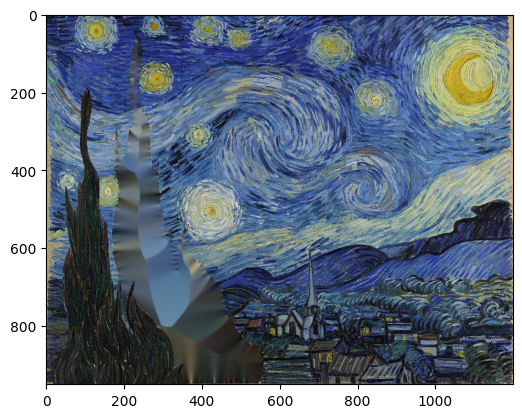

In [8]:
def insert_element(background, element, mask, position):
    """
    Inserts an element onto a background image at a specified position.

    Parameters:
    background (numpy.ndarray): The background image.
    element (numpy.ndarray): The element to be inserted onto the background image.
    mask (numpy.ndarray): The mask indicating the region of the element to be inserted.
    position (tuple): The position (x, y) where the element should be inserted (center).

    Returns:
    numpy.ndarray: The modified background image with the element inserted.

    """
    adj_position = (position[0] - element.shape[0] // 2, position[1] - element.shape[1] // 2)

    #Element is out of bounds y axis
    if adj_position[0] + element.shape[0] > background.shape[0]:
        element = element[:background.shape[0] - adj_position[0]]
        mask = mask[:background.shape[0] - adj_position[0]]
    if adj_position[0] < 0:
        mask = mask[-adj_position[0]:]
        element = element[-adj_position[0]:]
        adj_position = (0, adj_position[1])
    # Checking if the element is out of bounds x axis
    if adj_position[1] + element.shape[1] > background.shape[1]:
        element = element[:, :background.shape[1] - adj_position[1]]
        mask = mask[:, :background.shape[1] - adj_position[1]]
    if adj_position[1] < 0:
        mask = mask[:, -adj_position[1]:]
        element = element[:, -adj_position[1]:]
        adj_position = (adj_position[0], 0)

    globalMask = np.zeros_like(background)
    globalMask[adj_position[0]:adj_position[0]+element.shape[0], adj_position[1]:adj_position[1]+element.shape[1]] = mask
    globalMask = globalMask.any(axis=2).astype(bool)

    globalImage = np.zeros_like(background)
    globalImage[adj_position[0]:adj_position[0]+element.shape[0], adj_position[1]:adj_position[1]+element.shape[1]] = element

    background[globalMask] = globalImage[globalMask]

    return background

new = telea.copy()
insert_element(new, cut_img, cut_mask, (center_y+130, center_x-130))

plt.imshow(new)
plt.show()



## Flipping

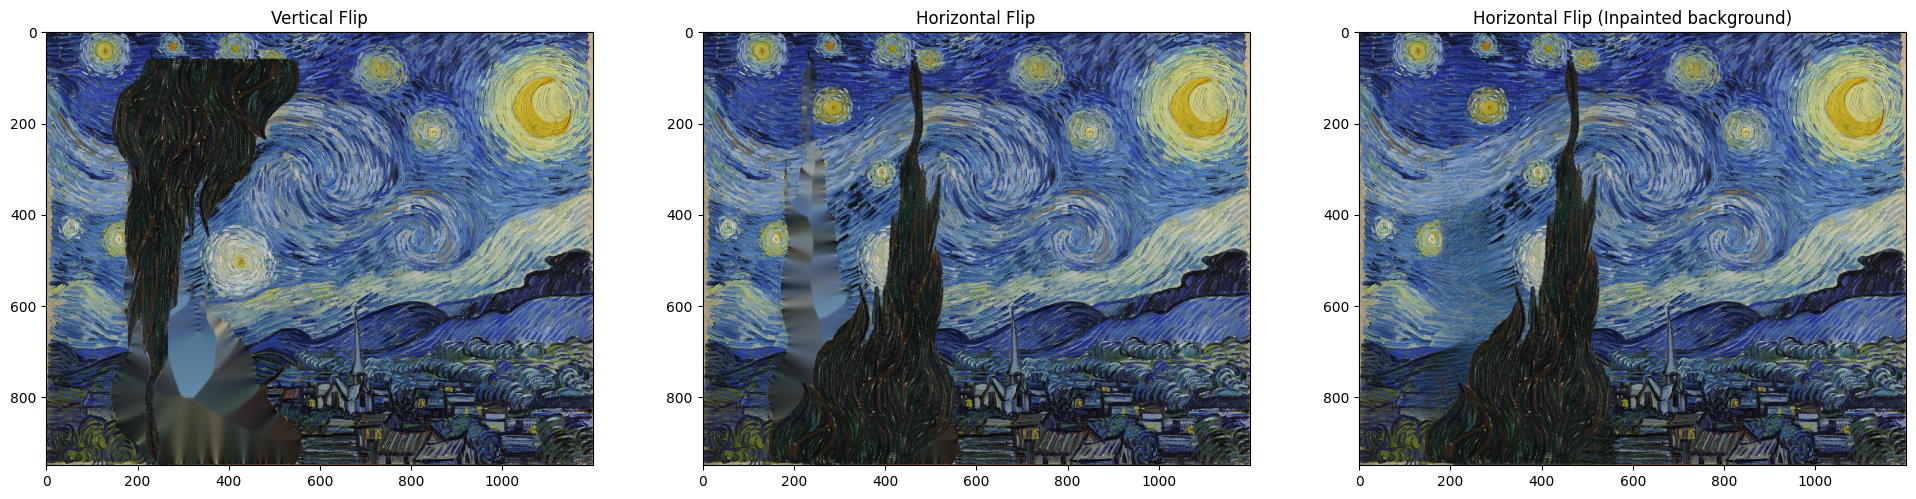

In [9]:
horizontal_flip_img = cv2.flip(cut_img, 1)
horizontal_flip_mask = cv2.flip(cut_mask, 1)

vertical_flip_img = cv2.flip(cut_img, 0)
vertical_flip_mask = cv2.flip(cut_mask, 0)

horizontal_flip = telea.copy()
insert_element(horizontal_flip, horizontal_flip_img, horizontal_flip_mask, (center_y, center_x))

vertical_flip = telea.copy()
insert_element(vertical_flip, vertical_flip_img, vertical_flip_mask, (center_y, center_x))

inpainted_horizontal_flip = inpainted_background.copy()
insert_element(inpainted_horizontal_flip, horizontal_flip_img, horizontal_flip_mask, (center_y, center_x))

# Display
fig, axs = plt.subplots(1, 3, figsize=(24, 10))

# Vertical Flip
axs[0].imshow(vertical_flip)
axs[0].set_title('Vertical Flip')

# Horizontal Flip
axs[1].imshow(horizontal_flip)
axs[1].set_title('Horizontal Flip')

# Horizontal Flip
axs[2].imshow(inpainted_horizontal_flip)
axs[2].set_title('Horizontal Flip (Inpainted background)')

plt.show()

## Rotation

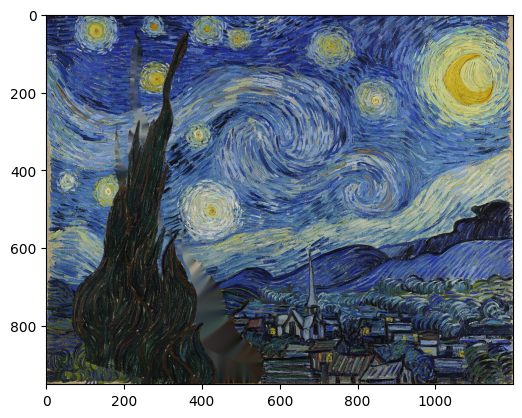

In [10]:
def rotation(img: np.ndarray, mask: np.ndarray):
    """
    Rotate the input image and mask by a random angle.

    Args:
        img (np.ndarray): The input image as a NumPy array.
        mask (np.ndarray): The input mask as a NumPy array.

    Returns:
        dict: A dictionary containing the rotated image and mask.
            - 'img' (np.ndarray): The rotated image as a NumPy array.
            - 'mask' (np.ndarray): The rotated mask as a NumPy array.
    """
    
    # Adding padding for rotation
    diagonal = int(np.sqrt(img.shape[0] ** 2 + img.shape[1] ** 2))
    padded_img = np.zeros((diagonal, diagonal, 3), dtype=np.uint8)
    padded_img[(diagonal - img.shape[0]) // 2:(diagonal - img.shape[0]) // 2 + img.shape[0], (diagonal - img.shape[1]) // 2:(diagonal - img.shape[1]) // 2 + img.shape[1]] = img

    padded_mask = np.zeros((diagonal, diagonal, 3), dtype=np.uint8)
    padded_mask[(diagonal - mask.shape[0]) // 2:(diagonal - mask.shape[0]) // 2 + mask.shape[0], (diagonal - mask.shape[1]) // 2:(diagonal - mask.shape[1]) // 2 + mask.shape[1]] = mask
    
    # Random rotation angle
    angle = random.randint(-45, 45)
    rotation_matrix = cv2.getRotationMatrix2D((diagonal // 2, diagonal // 2), angle, 1)

    # Rotate the image
    rotated_img = cv2.warpAffine(padded_img, rotation_matrix, (diagonal, diagonal))
    rotated_mask = cv2.warpAffine(padded_mask, rotation_matrix, (diagonal, diagonal))

    return {
        'img': rotated_img,
        'mask': rotated_mask
    }

augmented = rotation(cut_img, cut_mask)
rotated = telea.copy()
insert_element(rotated, augmented['img'], augmented['mask'], (center_y, center_x))

plt.imshow(rotated)
plt.show()

## Brightness


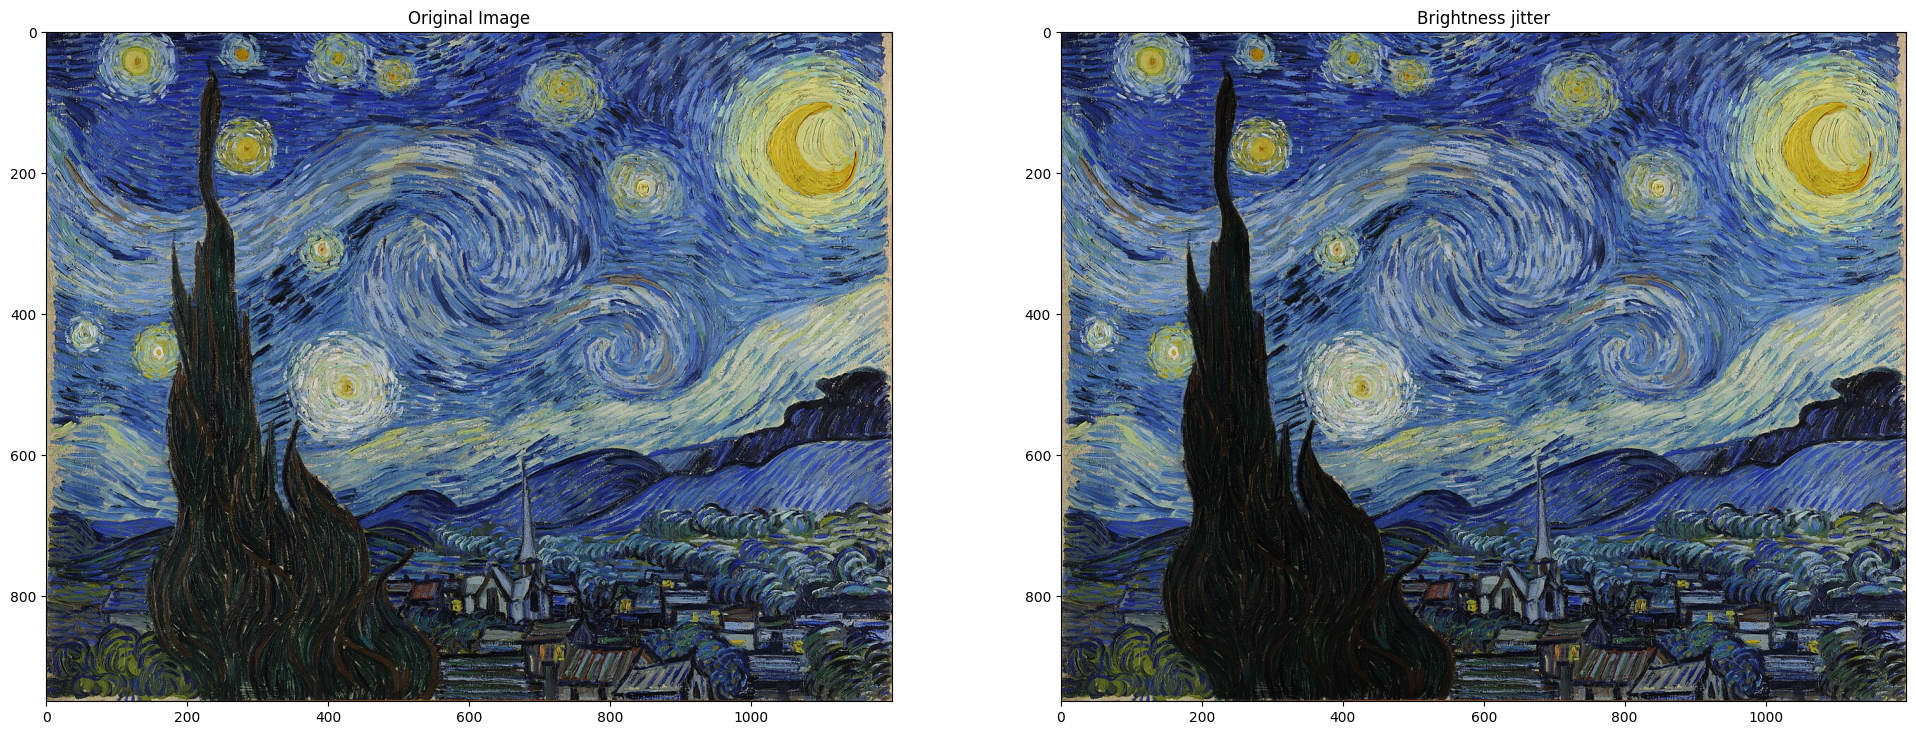

In [16]:
def brightness_jitter(img: np.ndarray, mask: np.ndarray) -> dict:
    """
    Adjusts the brightness of the input image and mask by a random factor.

    Args:
        img (np.ndarray): The input image as a NumPy array.
        mask (np.ndarray): The input mask as a NumPy array.

    Returns:
        dict: A dictionary containing the image and mask with adjusted brightness.
            - 'img' (np.ndarray): The image with adjusted brightness as a NumPy array.
            - 'mask' (np.ndarray): The mask with adjusted brightness as a NumPy array.
    """
    # Random brightness factor
    brightness_factor = random.uniform(0.5, 1.5)

    # Adjust the brightness of the image
    adjusted_img = cv2.convertScaleAbs(img, alpha=brightness_factor, beta=0)
    adjusted_img = np.clip(adjusted_img, 0, 255)

    return {
        'img': adjusted_img,
        'mask': mask
    }

brightness_jitter(cut_img, cut_mask)

augmented = brightness_jitter(cut_img, cut_mask)
brightness_shift = telea.copy()
_ = insert_element(brightness_shift, augmented['img'], augmented['mask'], (center_y, center_x))

# Display
fig, axs = plt.subplots(1, 2, figsize=(24, 10))

axs[0].imshow(img)
axs[0].set_title('Original Image')

axs[1].imshow(brightness_shift)
axs[1].set_title('Brightness jitter')

plt.show()

## Removal

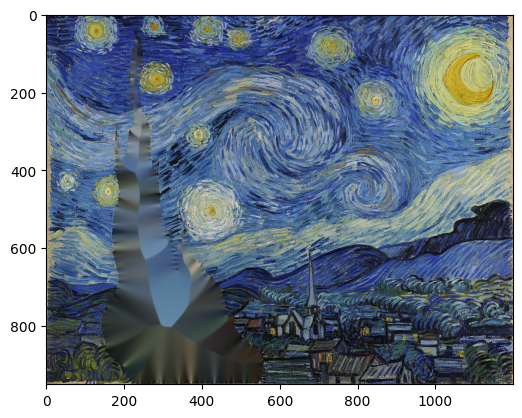

In [14]:
def removal(img: np.ndarray, mask: np.ndarray) -> dict:
    """
    Removes the object from the input image using the provided mask.

    Args:
        img (np.ndarray): The input image as a NumPy array.
        mask (np.ndarray): The input mask as a NumPy array.

    Returns:
        dict: A dictionary containing the empty image
    """

    return {
        'img': img,
        'mask': np.zeros_like(mask)
    }

augmented = removal(cut_img, cut_mask)
removed = telea.copy()
insert_element(removed, augmented['img'], augmented['mask'], (center_y, center_x))

plt.imshow(removed)
plt.show()

## Scale

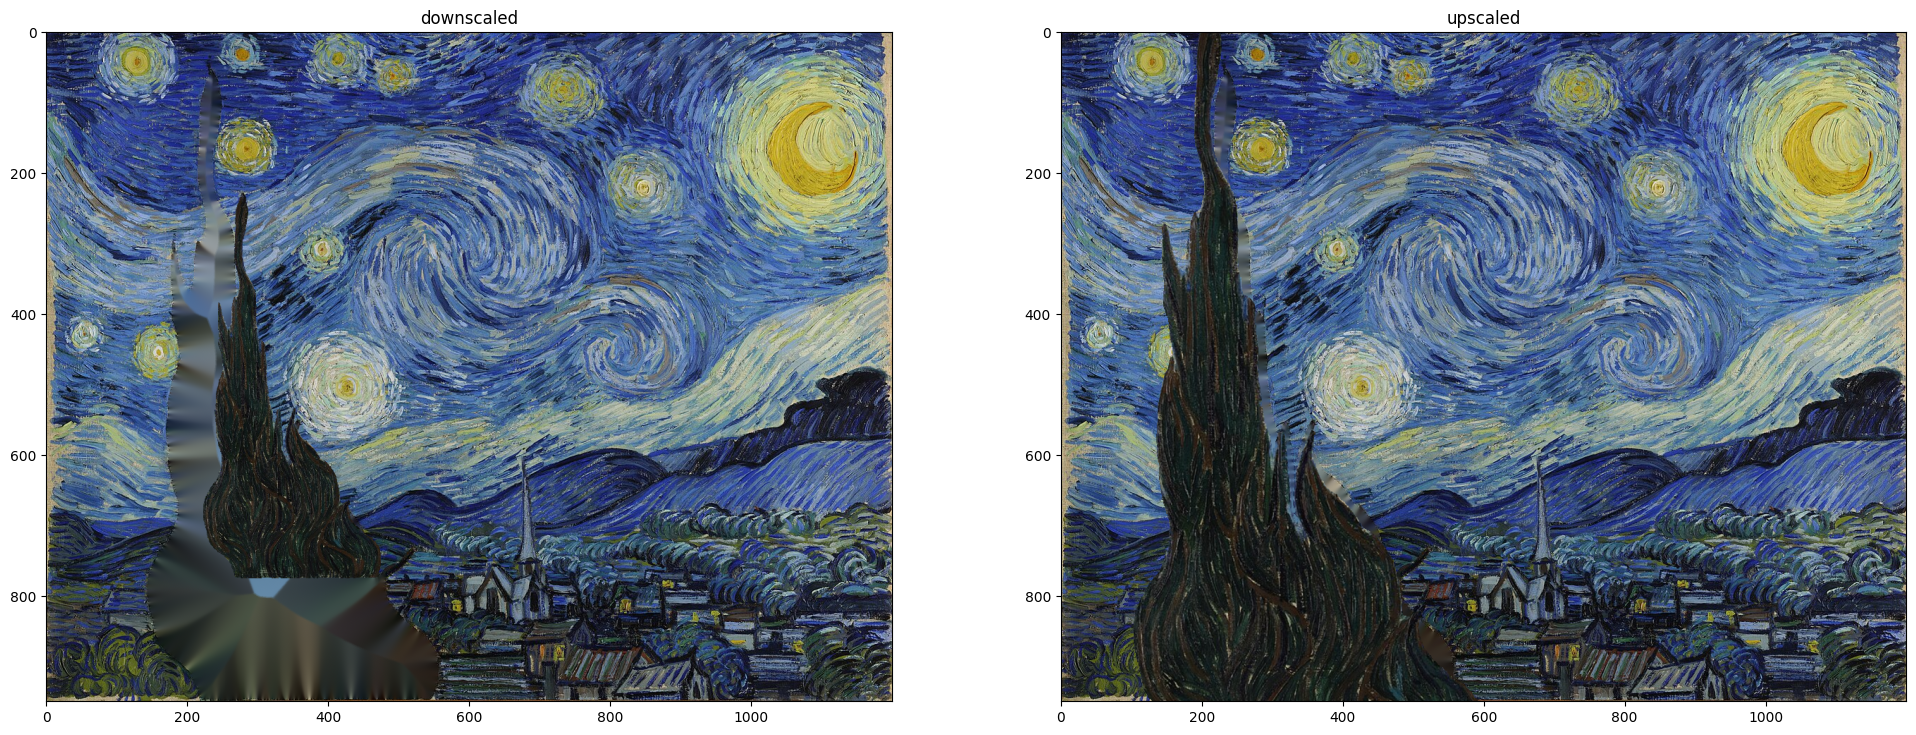

In [63]:
def downscale(img: np.ndarray, mask: np.ndarray) -> dict:
    """
    Downscale the input image and mask by a random factor.

    Args:
        img (np.ndarray): The input image as a NumPy array.
        mask (np.ndarray): The input mask as a NumPy array.

    Returns:
        dict: A dictionary containing the downscaled image and mask.
            - 'img' (np.ndarray): The downscaled image as a NumPy array.
            - 'mask' (np.ndarray): The downscaled mask as a NumPy array.
    """
    # Random scaling factor
    scaling_factor = random.uniform(0.5, 0.8)

    # Downscale the image
    downscaled_img = cv2.resize(img, None, fx=scaling_factor, fy=scaling_factor, interpolation=cv2.INTER_LINEAR)
    downscaled_mask = cv2.resize(mask, None, fx=scaling_factor, fy=scaling_factor, interpolation=cv2.INTER_LINEAR)

    return {
        'img': downscaled_img,
        'mask': downscaled_mask
    }

def upscale(img: np.ndarray, mask: np.ndarray) -> dict:
    """
    Upscale the input image and mask by a random factor.

    Args:
        img (np.ndarray): The input image as a NumPy array.
        mask (np.ndarray): The input mask as a NumPy array.

    Returns:
        dict: A dictionary containing the upscaled image and mask.
            - 'img' (np.ndarray): The upscaled image as a NumPy array.
            - 'mask' (np.ndarray): The upscaled mask as a NumPy array.
    """
    # Random scaling factor
    scaling_factor = random.uniform(1.1, 1.4)

    # Upscale the image
    upscaled_img = cv2.resize(img, None, fx=scaling_factor, fy=scaling_factor, interpolation=cv2.INTER_LINEAR)
    upscaled_mask = cv2.resize(mask, None, fx=scaling_factor, fy=scaling_factor, interpolation=cv2.INTER_LINEAR)

    return {
        'img': upscaled_img,
        'mask': upscaled_mask
    }

augmented_down = downscale(cut_img, cut_mask)
downscaled = telea.copy()
insert_element(downscaled, augmented_down['img'], augmented_down['mask'], (center_y, center_x))

augmented_up = upscale(cut_img, cut_mask)
upscaled = telea.copy()
insert_element(upscaled, augmented_up['img'], augmented_up['mask'], (center_y, center_x))

# Display
fig, axs = plt.subplots(1, 2, figsize=(24, 10))

# Vertical Flip
axs[0].imshow(downscaled)
axs[0].set_title('downscaled')

# Horizontal Flip
axs[1].imshow(upscaled)
axs[1].set_title('upscaled')

plt.show()